---
description: We define all the usefull functions to predict the potential VR from a given TR.
output-file: lstm.html
title: lstm

---

In [ ]:
#| hide
%load_ext autoreload
%autoreload 2

In [ ]:
#| default_exp lstm

In [ ]:
#| export
import logomaker
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model
import tensorflow.keras.backend as K
from tensorflow.keras.utils import register_keras_serializable
from dgrec.example_data import get_example_data_dir
import os
import matplotlib.pyplot as plt
from collections import Counter
EPS = 1e-8

2026-01-29 09:42:24.532782: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-29 09:42:24.556657: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-29 09:42:24.562868: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-29 09:42:24.580998: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-29 09:42:25.507637: W tensorflow/com

In [ ]:
# | export
# | hide

@register_keras_serializable(package="custom_losses")
def masked_categorical_crossentropy(y_true, y_pred):
    """
    y_true: one-hot (batch, time, vocab)
    y_pred: probs (batch, time, vocab)
    Padding rows in y_true assumed to be all zeros.
    Returns: scalar loss (averaged over examples)
    """
    # per-timestep categorical CE -> shape (batch, time)
    per_timestep_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    # mask = 1 where a true label exists (any non-zero in last axis)
    mask = tf.reduce_max(tf.abs(y_true), axis=-1)  # shape (batch, time)
    mask = tf.cast(mask, per_timestep_loss.dtype)

    # average loss per sequence (sum over time / count valid time steps)
    seq_loss = tf.reduce_sum(per_timestep_loss * mask, axis=1) \
               / (tf.reduce_sum(mask, axis=1) + EPS)

    # average across batch
    return tf.reduce_mean(seq_loss)

def masked_accuracy(y_true, y_pred):
    # y_true, y_pred shape: (batch, time, vocab_size)
    mask = K.cast(K.any(K.not_equal(y_true, 0), axis=-1), K.floatx())  # shape (batch, time)

    y_true_labels = K.argmax(y_true, axis=-1)
    y_pred_labels = K.argmax(y_pred, axis=-1)

    matches = K.cast(K.equal(y_true_labels, y_pred_labels), K.floatx())
    masked_matches = matches * mask

    return K.sum(masked_matches) / K.sum(mask)
    
# One-hot encoding function for DNA sequences (A, C, G, T)
def one_hot_encode(sequence, vocab_size=4):
    mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    integer_encoded = [mapping[base] for base in sequence]
    onehot_encoded = to_categorical(integer_encoded, num_classes=vocab_size)
    return onehot_encoded

def one_hot_decode(encoded_sequence):
    # Reverse the mapping used in encoding
    reverse_mapping = {0: 'A', 1: 'C', 2: 'G', 3: 'T'}
    
    # Get the index of the max value in each one-hot vector (which corresponds to the base index)
    integer_decoded = np.argmax(encoded_sequence, axis=1)
    
    # Convert the integer sequence back to the DNA bases using the reverse mapping
    decoded_sequence = ''.join([reverse_mapping[i] for i in integer_decoded])
    
    return decoded_sequence

def separate_model(model):
    """
    Disentangle the two-stage masked LSTM model into two parts:
      1. First BiLSTM + TimeDistributed Dense layers
      2. Second LSTM + Final Dense (with initial states for generation)
    """
    lstm_units = 16
    vocab_size = 4  # A, C, G, T

    # --- Part 1: First BiLSTM + Dense(s) ---
    inputs = layers.Input(shape=(None, vocab_size+1), name="DNA_input_sep")

    masked_seq = layers.Masking(mask_value=0.0)(inputs)
    bilstm_out = layers.Bidirectional(
        layers.LSTM(lstm_units//2, return_sequences=True),
        name="bilstm_1_sep"
    )(masked_seq)

    inter_dense_out = layers.TimeDistributed(
        layers.Dense(vocab_size+2, activation="softmax"),
        name="inter_dense_sep"
    )(bilstm_out)

    inter_dense_relu_out = layers.TimeDistributed(
        layers.Dense(2, activation="relu"),
        name="inter_dense_relu_sep"
    )(bilstm_out)

    # First part outputs both intermediate representations
    first_part_model = models.Model(
        inputs=inputs,
        outputs=[inter_dense_out, inter_dense_relu_out]
    )

    # Transfer weights by name
    first_part_model.get_layer("bilstm_1_sep").set_weights(
        model.get_layer("bilstm_1").get_weights()
    )
    first_part_model.get_layer("inter_dense_sep").set_weights(
        model.get_layer("intermediate_dense").get_weights()
    )
    first_part_model.get_layer("inter_dense_relu_sep").set_weights(
        model.get_layer("intermediate_dense_relu").get_weights()
    )

    # --- Part 2: Second LSTM + Final Dense ---
    inputs_seq = layers.Input(shape=(None, vocab_size+1), name="DNA_input2_sep")
    inputs_mut = layers.Input(shape=(None, 2 * vocab_size + 1), name="mutation_input2_sep")
    inter_out = layers.Input(shape=(None, vocab_size+2), name="inter_dense_out_sep")
    inter_relu_out = layers.Input(shape=(None, 2), name="inter_dense_relu_out_sep")
    initial_h = layers.Input(shape=(lstm_units,), name="init_h")
    initial_c = layers.Input(shape=(lstm_units,), name="init_c")

    concat_inputs = layers.Concatenate(name="concat_sep")(
        [inputs_seq, inputs_mut, inter_out, inter_relu_out]
    )
    masked_concat = layers.Masking(mask_value=0.0)(concat_inputs)

    lstm_out, state_h, state_c = layers.LSTM(
        lstm_units, return_sequences=True, return_state=True, name="lstm_2_sep"
    )(masked_concat, initial_state=[initial_h, initial_c])

    final_out = layers.TimeDistributed(
        layers.Dense(vocab_size, activation="softmax"),
        name="final_dense_sep"
    )(lstm_out)

    second_part_model = models.Model(
        inputs=[inputs_seq, inputs_mut, inter_out, inter_relu_out, initial_h, initial_c],
        outputs=[final_out, state_h, state_c]
    )

    # Transfer weights
    second_part_model.get_layer("lstm_2_sep").set_weights(
        model.get_layer("lstm_2").get_weights()
    )
    second_part_model.get_layer("final_dense_sep").set_weights(
        model.get_layer("final_dense").get_weights()
    )

    return first_part_model, second_part_model

data_path=get_example_data_dir()
model_name='LSTM_model_8_16.keras'
model_path=os.path.join(data_path,model_name)

model_TR_to_VR = load_model(model_path, custom_objects={"masked_accuracy": masked_accuracy}) #the LSTM model
firstmodel,secondmodel=separate_model(model_TR_to_VR)

def generate_sequence_from_onehot(X,firstmodel= firstmodel, secondmodel=secondmodel):
    """
    Generate a sequence using separated masked LSTM models.
    
    X: one-hot encoded sequence (batch, time, vocab_size+2)  # input_seq
    firstmodel: first part model (BiLSTM -> [softmax dense, ReLU dense])
    secondmodel: second part model (Concat -> LSTM -> final dense)
    """
    size, seq_length, input_dim = X.shape
    vocab_size = 4   # A, C, G, T
    lstm_units = 16

    # Initial states for second LSTM
    initial_h = np.zeros((size, lstm_units))
    initial_c = np.zeros((size, lstm_units))

    # First part (BiLSTM + two dense layers)
    inter_softmax_out, inter_relu_out = firstmodel.predict(X)

    # Mutation input (start token)
    X_mut = np.zeros((size, 1, vocab_size * 2 + 1))
    X_mut[:, 0, -1] = 1  # mark start

    generated_sequence = np.zeros((size, seq_length, vocab_size))

    for t in tqdm(range(seq_length), desc="Generating sequence"):
        output, new_h, new_c = secondmodel.predict([
            X[:, t:t+1, :],                       # input_seq at step t
            X_mut,                                # mutation input
            inter_softmax_out[:, t:t+1, :],       # intermediate softmax output
            inter_relu_out[:, t:t+1, :],          # intermediate relu output
            initial_h, initial_c                  # LSTM states
        ],verbose=0)

        # Sample next nucleotide
        probs = output[:, 0, :]  # (batch, vocab_size)
        next_word_idx = [np.random.choice(vocab_size, p=p) for p in probs]
        next_word_one_hot = np.zeros((size, vocab_size))
        next_word_one_hot[np.arange(size), next_word_idx] = 1

        generated_sequence[:, t, :] = next_word_one_hot

        # Update states
        initial_h, initial_c = new_h, new_c

        # Update mutation input for next step
        if t < seq_length - 1:
            X_mut[:, 0, :vocab_size] = X[:, t, :vocab_size]        # original nucleotide
            X_mut[:, 0, vocab_size:2*vocab_size] = next_word_one_hot  # predicted nucleotide
            X_mut[:, 0, -1] = 0  # remove start flag after t=0

    return generated_sequence


def sequences_same_length(sequences):
    """
    Check if all sequences in a list have the same length.
    
    Parameters:
    - sequences: list of sequences (e.g., strings, lists, or arrays)
    
    Returns:
    - bool: True if all sequences have the same length, False otherwise.
    """
    # Get the length of the first sequence
    first_length = len(sequences[0])

    # Check if all sequences have the same length
    for seq in sequences:
        if len(seq) != first_length:
            return False

    return True


def pad_sequence(seq, maxlen, padding_value=0):
    pad_width = ((0, maxlen - seq.shape[0]), (0, 0))  # pad rows only
    return np.pad(seq, pad_width, mode='constant', constant_values=padding_value)


codon_usage_ecoli = {
    "F": {"TTT": 0.57, "TTC": 0.43},
    "L": {"TTA": 0.15, "TTG": 0.12, "CTT": 0.12, "CTC": 0.10, "CTA": 0.05, "CTG": 0.46},
    "S": {"TCT": 0.11, "TCC": 0.11, "TCA": 0.15, "TCG": 0.16, "AGT": 0.14, "AGC": 0.33},
    "Y": {"TAT": 0.53, "TAC": 0.47},
    "*": {"TAA": 0.64, "TAG": 0.00, "TGA": 0.36},
    "C": {"TGT": 0.42, "TGC": 0.58},
    "W": {"TGG": 1.00},
    "P": {"CCT": 0.17, "CCC": 0.13, "CCA": 0.14, "CCG": 0.55},
    "H": {"CAT": 0.55, "CAC": 0.45},
    "Q": {"CAA": 0.30, "CAG": 0.70},
    "R": {"CGT": 0.36, "CGC": 0.44, "CGA": 0.07, "CGG": 0.07, "AGA": 0.07, "AGG": 0.00},
    "I": {"ATT": 0.58, "ATC": 0.35, "ATA": 0.07},
    "M": {"ATG": 1.00},
    "T": {"ACT": 0.16, "ACC": 0.47, "ACA": 0.13, "ACG": 0.24},
    "N": {"AAT": 0.47, "AAC": 0.53},
    "K": {"AAA": 0.73, "AAG": 0.27},
    "V": {"GTT": 0.25, "GTC": 0.18, "GTA": 0.17, "GTG": 0.40},
    "A": {"GCT": 0.11, "GCC": 0.31, "GCA": 0.20, "GCG": 0.38},
    "D": {"GAT": 0.65, "GAC": 0.35},
    "E": {"GAA": 0.70, "GAG": 0.30},
    "G": {"GGT": 0.29, "GGC": 0.46, "GGA": 0.13, "GGG": 0.12}
}

# Genetic code: codon -> amino acid
genetic_code = {}
for aa, codons in codon_usage_ecoli.items():
    for codon in codons:
        genetic_code[codon] = aa

CODON_TO_AA = {
    'ATA': 'I', 'ATC': 'I', 'ATT': 'I', 'ATG': 'M',
    'ACA': 'T', 'ACC': 'T', 'ACG': 'T', 'ACT': 'T',
    'AAC': 'N', 'AAT': 'N', 'AAA': 'K', 'AAG': 'K',
    'AGC': 'S', 'AGT': 'S', 'AGA': 'R', 'AGG': 'R',
    'CTA': 'L', 'CTC': 'L', 'CTG': 'L', 'CTT': 'L',
    'CCA': 'P', 'CCC': 'P', 'CCG': 'P', 'CCT': 'P',
    'CAC': 'H', 'CAT': 'H', 'CAA': 'Q', 'CAG': 'Q',
    'CGA': 'R', 'CGC': 'R', 'CGG': 'R', 'CGT': 'R',
    'GTA': 'V', 'GTC': 'V', 'GTG': 'V', 'GTT': 'V',
    'GCA': 'A', 'GCC': 'A', 'GCG': 'A', 'GCT': 'A',
    'GAC': 'D', 'GAT': 'D', 'GAA': 'E', 'GAG': 'E',
    'GGA': 'G', 'GGC': 'G', 'GGG': 'G', 'GGT': 'G',
    'TCA': 'S', 'TCC': 'S', 'TCG': 'S', 'TCT': 'S',
    'TTC': 'F', 'TTT': 'F', 'TTA': 'L', 'TTG': 'L',
    'TAC': 'Y', 'TAT': 'Y', 'TAA': '*', 'TAG': '*',
    'TGC': 'C', 'TGT': 'C', 'TGA': '*', 'TGG': 'W'
}


AA = '-ACDEFGHIKLMNPQRSTVWY'
AA_IDS = {k: i for i, k in enumerate(AA)}


AA_TO_CODONS = {
    'A': ['GCT', 'GCC', 'GCA', 'GCG'],  # Alanine
    'C': ['TGT', 'TGC'],               # Cysteine
    'D': ['GAT', 'GAC'],               # Aspartic acid
    'E': ['GAA', 'GAG'],               # Glutamic acid
    'F': ['TTT', 'TTC'],               # Phenylalanine
    'G': ['GGT', 'GGC', 'GGA', 'GGG'], # Glycine
    'H': ['CAT', 'CAC'],               # Histidine
    'I': ['ATT', 'ATC', 'ATA'],        # Isoleucine
    'K': ['AAA', 'AAG'],               # Lysine
    'L': ['TTA', 'TTG', 'CTT', 'CTC', 'CTA', 'CTG'],  # Leucine
    'M': ['ATG'],                      # Methionine (Start codon)
    'N': ['AAT', 'AAC'],               # Asparagine
    'P': ['CCT', 'CCC', 'CCA', 'CCG'], # Proline
    'Q': ['CAA', 'CAG'],               # Glutamine
    'R': ['CGT', 'CGC', 'CGA', 'CGG', 'AGA', 'AGG'],  # Arginine
    'S': ['TCT', 'TCC', 'TCA', 'TCG', 'AGT', 'AGC'],  # Serine
    'T': ['ACT', 'ACC', 'ACA', 'ACG'], # Threonine
    'V': ['GTT', 'GTC', 'GTA', 'GTG'], # Valine
    'W': ['TGG'],                      # Tryptophan
    'Y': ['TAT', 'TAC'],               # Tyrosine
    '*': ['TAA', 'TAG', 'TGA'],        # Stop codons
    '-': []                            # Gap (no codons)
}

def nt_to_codons(nt_sequence):
    """
    Converts a nucleotide sequence into a list of codons.
    
    Args:
        nt_sequence (str): A string of nucleotides (e.g., "ATGGCATGA").
        
    Returns:
        list: A list of codons (e.g., ['ATG', 'GCA', 'TGA']).
    """
    # Ensure the sequence length is a multiple of 3 by trimming extra nucleotides
    trimmed_sequence = nt_sequence[:len(nt_sequence) // 3 * 3]
    
    # Split the sequence into codons (groups of 3 nucleotides)
    codons = [trimmed_sequence[i:i+3] for i in range(0, len(trimmed_sequence), 3)]
    
    return codons

def codons_to_aa(codons):
    """
    Converts a list of codons into a sequence of amino acids.
    
    Args:
        codons (list): A list of codon strings (e.g., ['ATG', 'GCA', 'TGA']).
        
    Returns:
        str: The translated amino acid sequence (e.g., 'M*A').
    """
    aa_sequence = ""
    for codon in codons:
        # Convert codon to amino acid; default to 'X' for invalid codons
        aa_sequence += CODON_TO_AA.get(codon, 'X')
    return aa_sequence

def nt_prot(nt):
    return codons_to_aa(nt_to_codons(nt))


I0000 00:00:1769676146.908568   33883 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1769676146.960514   33883 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1769676146.963116   33883 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1769676146.967757   33883 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [ ]:
#| export

def generate_sequences(X_seq): #X _seq is a list of sequences ATCG sequences (faster if same length)
    """
    Generate list of VR from list of TR (one TR-> one VR).
    Parameters:
    - X_seq: list of TR sequences (e.g., strings, lists, or arrays)
    Returns:
    - list: list of VR sequence strings given TR sequences (corresponding to the initial TR list).
    """
    X=[np.concatenate((one_hot_encode((X_seq[k])[::-1]),[[i] for i in range(len(X_seq[k]))]),axis=1) for k in range(len(X_seq))]
    if sequences_same_length(X_seq): # check that all sequences have same length: allow for fast generation
        Y=generate_sequence_from_onehot(np.array(X),firstmodel,secondmodel)
        return [one_hot_decode(y)[::-1] for y in Y] # return sequence in good order
    else:
        max_len = max(len(seq)+2 for seq in X_seq)
        length=np.array([len(seq) for seq in X_seq])
        X_padded = np.array([pad_sequence(seq, max_len) for seq in X])
        Y=generate_sequence_from_onehot(X_padded,firstmodel,secondmodel)
        return [(one_hot_decode(Y[i])[:length[i]])[::-1] for i in range(len(Y))] # return sequence in good order

def generate_sequences_oneTR(TR,n=1000):
    """
    Generate list of VR from one TR (one TR-> n VR).
    Parameters:
    - TR: one TR sequence (e.g., strings, lists, or arrays)
    -n: integer corresponding to the number of VR to generate
    Returns:
    - list: list of n VR sequence strings given the one TR sequence.
    """
    TR_list=[TR]*n
    return generate_sequences(TR_list)

In [ ]:
generate_sequences_oneTR('CGTAAACCGGACCTAGTTTAGTTCTTAGACCAAGGTACATATCCCCGTAACATAAGACGCGACTGGGCCC',n=10)

2026-01-29 09:42:30.623103: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


Generating sequence: 100%|██████████████████████| 70/70 [00:07<00:00,  9.88it/s]


['CGTAAACCGGACCTAGTTTAGTTCTTAGGCCAAGGTACATATCCCCGTTACATCAGACGCGACTGGGCCC',
 'CGTAAACCGGACCTAGTTTAGTTCTTAGACCAGGGTACATATCCCCGTGGCATAAGACGCGACTGGGCCC',
 'CGTAAACCGGACCTAGTTTAGTTCTTAGCCCAGGGTACATATCCCCGTTACATAGGACGCGACTGGGCCC',
 'CGTAAACCGGACCTAGTTTAGTTCTTAGACCAAGGTACATATCCCCGTACCATAAGACGCGACTGGGCCC',
 'CGTAAACCGGACCTGGTTTAGTTCTTGGACCAAGGTGCATGTCCCCGTAGCATGAGGCGCGACTGGGCCC',
 'CGTAAACCGGACCTAGTTTAGTTCTTAGACCAAGGTGCATGTCCCCGTAACATAAGGCGCGACTGGGCCC',
 'CGTGTACCGGACCTGGTTTGGTTCTGAGCCCAAGGTACATGTCCCCGTGGCGTAAGTCGCGCCTGGGCCC',
 'CGTAAACCGGTCCTGGTTTAGTTCTTAGACCAAGGTACATATCCCCGTAACATAAGACGCGACTGGGCCC',
 'CGTAAACCGGACCTAGTTTAGTTCTTAGACCAAGGTACCTATCCCCGTAACATAAGACGCGACTGGGCCC',
 'CGTAAACCGGACCTAGTTTAGTTCTTAGACCAAGGTACATATCCCCGTAACCTAAGACGCGACTGGGCCC']

In [ ]:
#| export

def EvaluateTR_to_prot(TR, NDGR=100, offset=0):
    """
    Give the sequence logo of the proteins that are accessible to the TR via DGR.
    Parameters:
    - TR: one TR sequence (e.g., strings, lists, or arrays)
    - NDGR: integer corresponding to the number of VR to generate
    - offset: the offset to consider for nucleotide to protein translation
    Returns:
    - Counter: dictionnary of proteins with counts.
    """
    VR = generate_sequences_oneTR(TR, NDGR)
    Proteins = [nt_prot(vr[offset:]) for vr in VR]
    df = logomaker.alignment_to_matrix(
        sequences=Proteins,
        to_type='counts'
    )

    # normalize to probabilities
    df = df.div(df.sum(axis=1), axis=0)

    plt.figure(figsize=(12, 4))
    logomaker.Logo(
        df,
        color_scheme='chemistry',   # 👈 nice protein coloring
        shade_below=.5,
        fade_below=.5
    )
    plt.title("Protein Sequence Logo")
    plt.ylabel("Frequency")
    plt.show()
    return Counter(Proteins)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step 


Generating sequence: 100%|██████████████████████| 70/70 [00:08<00:00,  8.64it/s]
/home/regnier/tf_env/lib/python3.10/site-packages/logomaker/src/error_handling.py:58: UserWarning:  Warning: Character '*' is not in color_dict. Using black.
  warnings.warn(str(Error))


<Figure size 1200x400 with 0 Axes>

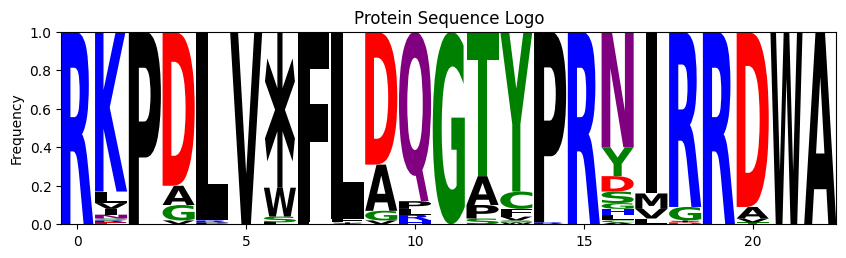

Counter({'RKPDLV*FLDQGTYPRNIRRDWA': 12,
         'RKPDLV*FLAQGTYPRNIRRDWA': 4,
         'RKPDLV*FLDQGTYPRDIRRDWA': 2,
         'RKPDLV*FLDPGTYPRNIRRDWA': 2,
         'RKPDLV*FLDHGTYPRNIRRDWA': 2,
         'RKPGLV*FLDQGTYPRNIRRDWA': 2,
         'RKPDLV*FLDQGTYPRNIRRAWA': 2,
         'RKPDLV*FLDQGTYPRNIGRDWA': 2,
         'RKPDLV*FLDQGPYPRNIRRDWA': 2,
         'RKPDLV*FFDQGTYPRNIRRDWA': 2,
         'RKPALV*FLAQGTYPRNIRRDWA': 2,
         'RKPGLV*FLDQGTFPRDIRRDWA': 1,
         'RKPDLV*FLDQGTYPRGIRRDWA': 1,
         'RKPDLV*FLDQGTYPRNIRRTWA': 1,
         'RVPALVWFLDQGTYPRNIRRDWA': 1,
         'RKPDLVWFLDPGAYPRDMRRAWA': 1,
         'RKPDLV*FLDQGTSPRNIRRDWA': 1,
         'RKPDLVWFLDQGTYPRNIRRDWA': 1,
         'RKPGLV*FLAQGTYPRNIRRDWA': 1,
         'RKPDLVWF*AQGTYPRNIRRDWA': 1,
         'RIPDLV*FLDQGTCPRYIRRDWA': 1,
         'RLPDLV*FLDQGTYPRNIRRDWA': 1,
         'RKPDLV*FLDQGTYPRHMGRDWA': 1,
         'RKPDLV*LLAQGACPRYIRRDWA': 1,
         'RKPALV*FLAQGAYPRYIRRVWA': 1,
         'RKPDLV*FLDQGPY

In [ ]:
EvaluateTR_to_prot('CGTAAACCGGACCTAGTTTAGTTCTTAGACCAAGGTACATATCCCCGTAACATAAGACGCGACTGGGCCC')

In [ ]:
#| export
from dgrec import predictions

def optimize_sequence_display_proteins(original_seq: str,
    frame_offset: int = 0,
    CHANGES: int = 6,
    freq_min: float = 0.2,
    N: int = 1,
    forbidden_positions: list[int] = [],
    threshold: float = 0.7,
    codon_usage: dict = codon_usage_ecoli,
    NDGR: int = 100
):
    """
    Optimize a DNA sequence via synonymous codon substitutions and shows the sequence logo for each of the optimal sequences.

    This function performs a beam-search–based optimization of a nucleotide
    sequence by iteratively proposing single-codon synonymous changes and
    evaluating them with the two scoring functions. The search stops early if a
    variant meets the specified score thresholds, otherwise the best Pareto-
    optimal solution is returned.

    Parameters
    ----------
    original_seq : str
        Original DNA sequence to optimize.
    frame_offset : int, default=0
        Reading-frame offset (0, 1, or 2) used when grouping codons.
    CHANGES : int, default=6
        Maximum number of codon substitutions allowed.
    freq_min : float, default=0.2
        Lowest usage frequency acceptable.
    N : int, default=1
        Number of putative TR to output.
    forbidden_positions : list[int], optional
        Nucleotide positions that must not be modified.
    threshold : float, default=0.7
        Minimum required value for both `Score_TRSp` and `Score_TRSpAvd` to
        accept a sequence as optimal.
    codon_usage : dict, optional
        Codon usage table of E. Coli mapping amino acids to codons and frequencies.
    NDGR : int, default=100
        Number of sequences to generate via the LSTM for sequence logo estimation. 
    Returns
    -------
    dict
        Dictionary containing:
        - `Original_Sequence` : str  
          Input DNA sequence.
        - `New_Variant` : str  
          Optimized DNA sequence.
        - `Rank` : int or None  
          rank of the sequence (by score).
        - `Score` : float or None  
          score of the selected variant (geometrical mean).
        - `Score_TRSp` : float or None  
          TR+Sp score of the selected variant.
        - `Score_TRSpAvd` : float or None  
          Avd+TR+Sp score of the selected variant.
        - `Proteins` : Counter
          The proteins that can are generated by the DGR.  
    Notes
    -----
    - The algorithm keeps only Pareto-optimal candidates at each iteration.
    - If no variant satisfies the threshold criteria, the best-scoring
      sequence after `CHANGES` iterations is returned.
    - Internal scoring and plotting are handled by `evaluate_sequences`.

    Examples
    --------
    ```python
    result = optimize_sequence("ATGGCTGCTTAA")
    result["New_Variant"]
    ```
    """
    record=predictions.optimize_sequence(
    original_seq,
    frame_offset,
    CHANGES,
    freq_min,
    N,
    forbidden_positions,
    threshold,
    codon_usage
)
    for i in range(len(record)):
        Prot=EvaluateTR_to_prot(record[i]["New_Variant"],NDGR=NDGR,offset=frame_offset)
        record[i]['Proteins']=Prot
    return record

CCCAATACTCTCATAAGGTGCACAGATGACAGTCTCGACGCGCCAGACATTACTCTTGGATGCTTGACGT


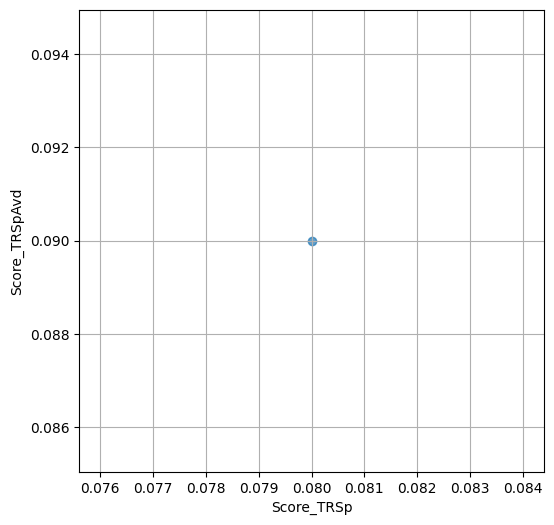

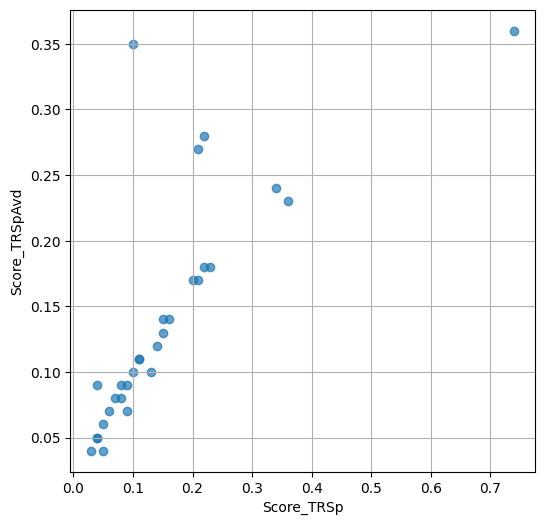

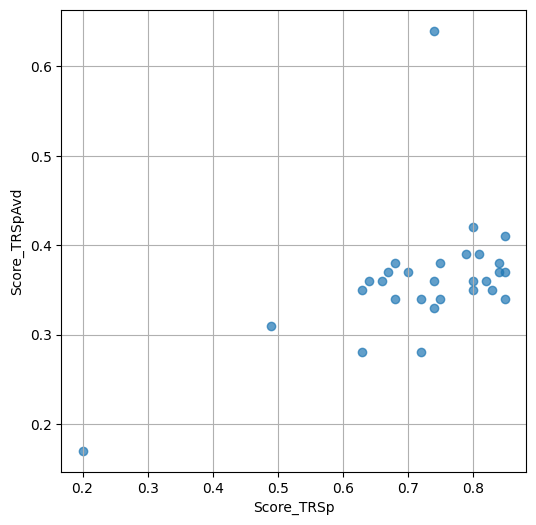

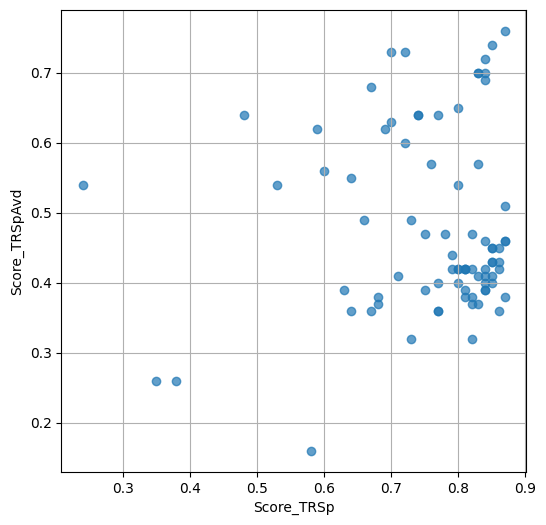

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


Generating sequence: 100%|██████████████████████| 70/70 [00:10<00:00,  6.48it/s]


<Figure size 1200x400 with 0 Axes>

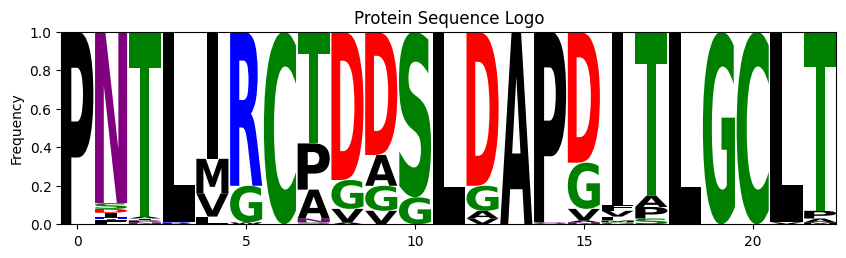

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Generating sequence: 100%|██████████████████████| 70/70 [00:09<00:00,  7.35it/s]


<Figure size 1200x400 with 0 Axes>

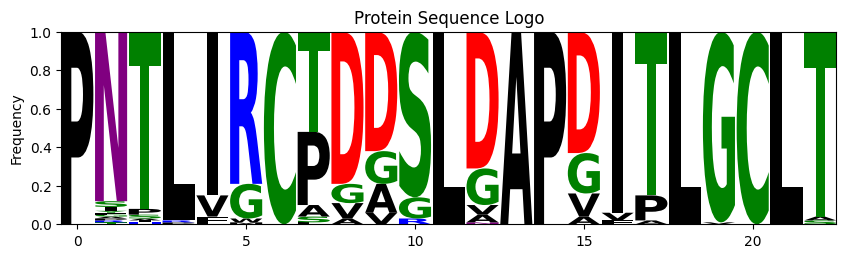

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Generating sequence: 100%|██████████████████████| 70/70 [00:09<00:00,  7.31it/s]


<Figure size 1200x400 with 0 Axes>

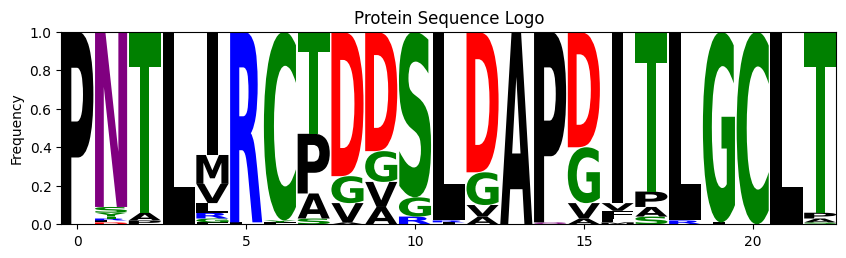

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


Generating sequence: 100%|██████████████████████| 70/70 [00:09<00:00,  7.63it/s]


<Figure size 1200x400 with 0 Axes>

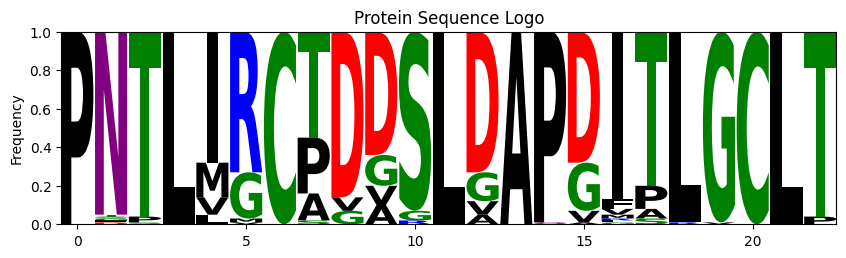

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


Generating sequence: 100%|██████████████████████| 70/70 [00:09<00:00,  7.16it/s]
/home/regnier/tf_env/lib/python3.10/site-packages/logomaker/src/error_handling.py:58: UserWarning:  Warning: Character '*' is not in color_dict. Using black.
  warnings.warn(str(Error))


<Figure size 1200x400 with 0 Axes>

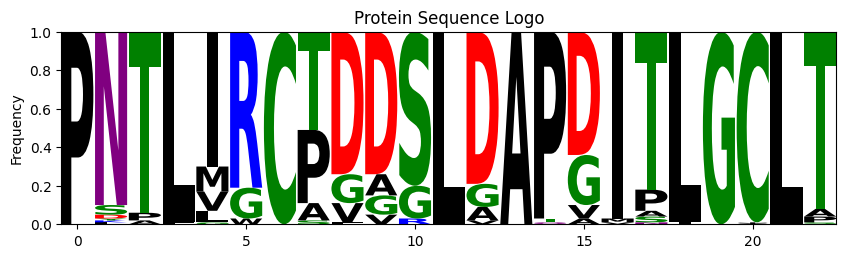

[{'Original_Sequence': 'CCCAATACTCTCATAAGGTGCACAGATGACAGTCTCGACGCGCCAGACATTACTCTTGGATGCTTGACGT',
  'New_Variant': 'CCGAATACTCTCATAAGGTGCACCGATGACAGTCTCGACGCGCCAGACATTACTCTTGGATGTTTGACGT',
  'Score': 0.8131420540102449,
  'Rank': 1,
  'Score_TRSp': 0.87,
  'Score_TRSpAvd': 0.76,
  'Proteins': Counter({'PNTLIRCTDDSLDAPDITLGCLP': 3,
           'PNTLIRCTDDSLDAPDITLGCLT': 2,
           'PNTLIRCTDASLDAPDITLGCLT': 2,
           'PNTLVRCTDDGLDAPDITLGCLT': 2,
           'PNTLIRCTDDSLAAPDITLGCLT': 2,
           'PNTLIRCPDDSLDAPDITLGCLT': 2,
           'PNTLIRCTDDSLDAPDIPLGCLT': 2,
           'PNTLVGCTGDSLDAPDITLGCLT': 2,
           'PSTLMRCTDDSLDAPDITLGCLT': 2,
           'PNTLIRCTGDSLDAPGITLGCLT': 2,
           'PNTLIRCAGDSLDAPDITLGCLT': 2,
           'PNTLIGCADDSLDAPGITLGCLT': 1,
           'PLTLIRCAGDSLGAPDITLGCLT': 1,
           'PNTLLRCPDDSLDAPDIPLGCLT': 1,
           'PNTLIRCPGGSLDAPGITLGCLT': 1,
           'PNTLIRCADGSLDAPDITLGCLT': 1,
           'PNTLIRCTDDSLDAPDISLGCLT': 1,
           '

In [ ]:
seq = ''.join(np.random.choice(['A','T','C','G'], size=70))
print(seq)

optimize_sequence_display_proteins(seq,N=5,CHANGES=6)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()